In [1]:
!pip install scikit-learn==1.7.2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Load data
file_path = '/content/sample_data/Warfarin Dose Data Collection – Mechanical Heart Valve Patients(1-34).csv'
df = pd.read_csv(file_path)

# Fix column names by stripping whitespace and special chars
cols = df.columns.str.strip().str.replace('\\xa0', ' ', regex=False)
df.columns = cols

# Select features and target variable
features = ['Age', 'Gender', 'Valve Position', 'Current Warfarin Dose (mg/day)', 'Current INR Value']
target = 'Recommended Dose (Test 3)'

# Prepare dataset
X = df[features]
y = df[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical features
numeric_features = ['Age', 'Current Warfarin Dose (mg/day)', 'Current INR Value']
categorical_features = ['Gender', 'Valve Position']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit preprocessor on train data and transform
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Data augmentation through upsampling of minority dose samples
train_data = np.hstack((X_train_processed, y_train.values.reshape(-1, 1)))
median_y = np.median(y_train)

train_minority = train_data[y_train.values < median_y]
train_majority = train_data[y_train.values >= median_y]

train_minority_upsampled = resample(train_minority, replace=True,
                                    n_samples=len(train_majority), random_state=42)

train_balanced = np.vstack([train_majority, train_minority_upsampled])
np.random.shuffle(train_balanced)

X_train_balanced = train_balanced[:, :-1]
y_train_balanced = train_balanced[:, -1]

# Initialize models
model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=42)
model_svr = SVR()

# Train models on augmented data
model_lr.fit(X_train_balanced, y_train_balanced)
model_rf.fit(X_train_balanced, y_train_balanced)
model_svr.fit(X_train_balanced, y_train_balanced)

# Predict on test data
y_pred_lr = model_lr.predict(X_test_processed)
y_pred_rf = model_rf.predict(X_test_processed)
y_pred_svr = model_svr.predict(X_test_processed)

# Evaluate performance
metrics = {
    'Linear Regression': {'MSE': mean_squared_error(y_test, y_pred_lr), 'R2': r2_score(y_test, y_pred_lr)},
    'Random Forest': {'MSE': mean_squared_error(y_test, y_pred_rf), 'R2': r2_score(y_test, y_pred_rf)},
    'SVR': {'MSE': mean_squared_error(y_test, y_pred_svr), 'R2': r2_score(y_test, y_pred_svr)}
}

print(metrics)


{'Linear Regression': {'MSE': 1.5228295528048226, 'R2': 0.7679046715787362}, 'Random Forest': {'MSE': 1.499257142857143, 'R2': 0.7714973561430793}, 'SVR': {'MSE': 2.8325402005502385, 'R2': 0.5682909181120943}}


Best model: Random Forest
Model saved to random_forest_warfarin_model.pkl


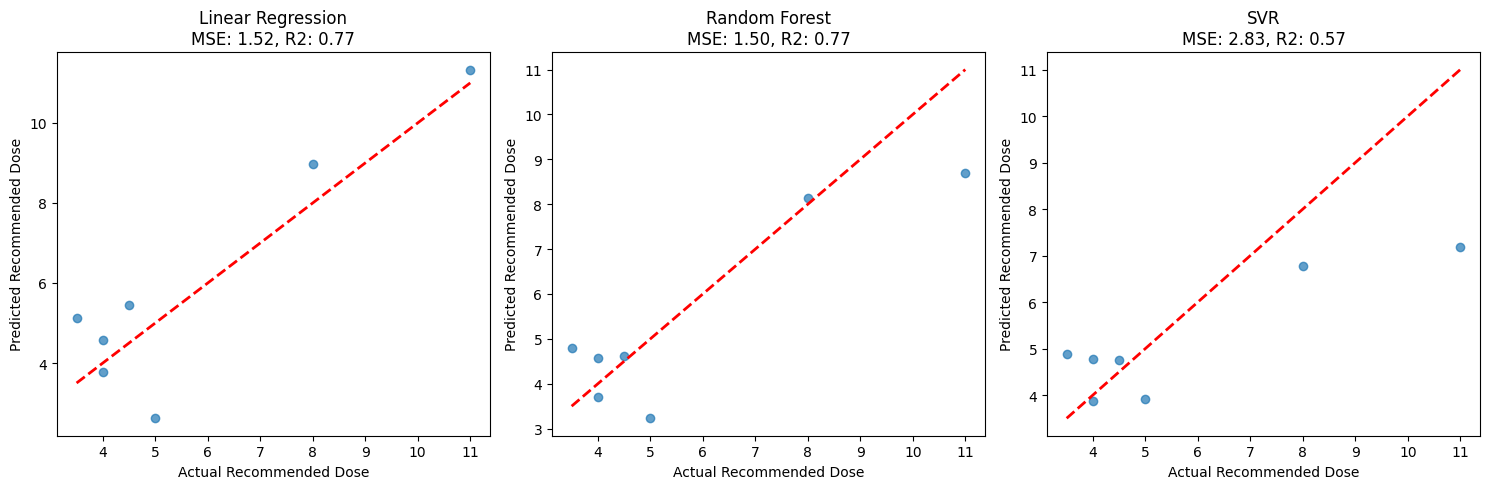

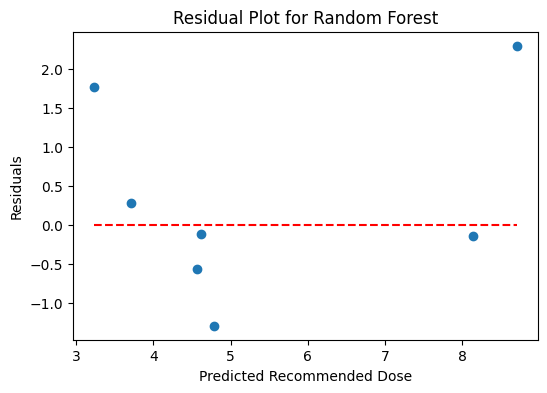

In [3]:
import matplotlib.pyplot as plt
import joblib

# Identify best model (lowest MSE)
best_model_name = min(metrics, key=lambda k: metrics[k]['MSE'])
print(f"Best model: {best_model_name}")

if best_model_name == 'Linear Regression':
    best_model = model_lr
elif best_model_name == 'Random Forest':
    best_model = model_rf
else:
    best_model = model_svr

# Save the best model
joblib_file = f"{best_model_name.replace(' ', '_').lower()}_warfarin_model.pkl"
joblib.dump(best_model, joblib_file)
print(f"Model saved to {joblib_file}")

# Plotting actual vs predicted for each model
plt.figure(figsize=(15, 5))

models_preds = {
    'Linear Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'SVR': y_pred_svr
}

for i, (model_name, y_pred) in enumerate(models_preds.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Recommended Dose')
    plt.ylabel('Predicted Recommended Dose')
    plt.title(f'{model_name}\nMSE: {metrics[model_name]["MSE"]:.2f}, R2: {metrics[model_name]["R2"]:.2f}')

plt.tight_layout()
plt.show()

# Residual plot for best model
plt.figure(figsize=(6, 4))
residuals = y_test - best_model.predict(X_test_processed)
plt.scatter(best_model.predict(X_test_processed), residuals)
plt.hlines(y=0, xmin=min(best_model.predict(X_test_processed)), xmax=max(best_model.predict(X_test_processed)), colors='r', linestyles='dashed')
plt.xlabel('Predicted Recommended Dose')
plt.ylabel('Residuals')
plt.title(f'Residual Plot for {best_model_name}')
plt.show()


In [4]:
import joblib

# Save the preprocessor pipeline after fitting
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessor saved as preprocessor.pkl")


Preprocessor saved as preprocessor.pkl


In [5]:
import sklearn
print(sklearn.__version__)


1.7.2
